## Timeseries of rainfall rates from E3SM vs CPOL

In [55]:
import warnings
warnings.filterwarnings("ignore")
import xarray
import pyart
import dask.bag as db
import cartopy.crs as ccrs

from dask_jobqueue import SLURMCluster
from glob import glob
from datetime import datetime
from cartopy import feature
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
e3sm_path = '/lcrc/group/earthscience/cmdv/e3sm/*.nc'
ds_e3sm = xarray.open_mfdataset(e3sm_path)

In [3]:
ds_e3sm

<xarray.Dataset>
Dimensions:       (ilev: 73, lat: 129, lev: 72, lon: 256, nbnd: 2, slat: 128, slon: 256, time: 4129)
Coordinates:
  * lat           (lat) float64 -90.0 -88.59 -87.19 -85.78 -84.38 -82.97 ...
  * lon           (lon) float64 0.0 1.406 2.812 4.219 5.625 7.031 8.438 ...
  * slat          (slat) float64 -89.3 -87.89 -86.48 -85.08 -83.67 -82.27 ...
  * slon          (slon) float64 -0.7031 0.7031 2.109 3.516 4.922 6.328 ...
  * ilev          (ilev) float64 0.1 0.1477 0.218 0.3219 0.4753 0.7017 1.036 ...
  * lev           (lev) float64 0.1238 0.1828 0.2699 0.3986 0.5885 0.8689 ...
  * time          (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...
Dimensions without coordinates: nbnd
Data variables:
    w_stag        (time, slat) float64 dask.array<shape=(4129, 128), chunksize=(240, 128)>
    lat_bnds      (time, lat, nbnd) float64 dask.array<shape=(4129, 129, 2), chunksize=(240, 129, 2)>
    lon_bnds      (time, lon, nbnd) float64 dask.array<shape=(4129, 256, 2), chunk

## Let's reduce the dataset a bit, shall we?

In [4]:
ds_e3sm.lat.values
bounding_box_1 = np.logical_and.reduce((ds_e3sm.PRECC.lat.values > -13.55,ds_e3sm.PRECC.lat.values < -10.94))
bounding_box_2 = np.logical_and.reduce((ds_e3sm.PRECC.lon.values > 129.7, ds_e3sm.PRECC.lon.values < 132.3))
rain_darwin = ds_e3sm.PRECL[:,bounding_box_1, bounding_box_2] + ds_e3sm.PRECC[:,bounding_box_1, bounding_box_2]
rain_darwin = rain_darwin*3600*1e3
lat_bnds = ds_e3sm.lat_bnds[0,bounding_box_1,:].values
lon_bnds = ds_e3sm.lon_bnds[0,bounding_box_2,:].values
mean_rain_darwin = rain_darwin.mean(axis=[1,2])
print(rain_darwin)

<xarray.DataArray (time: 4129, lat: 2, lon: 2)>
dask.array<shape=(4129, 2, 2), dtype=float32, chunksize=(240, 2, 2)>
Coordinates:
  * lat      (lat) float64 -12.66 -11.25
  * lon      (lon) float64 130.8 132.2
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...


In [54]:
ds_e3sm.PRECL

<xarray.DataArray 'PRECL' (time: 4129, lat: 129, lon: 256)>
dask.array<shape=(4129, 129, 256), dtype=float32, chunksize=(240, 129, 256)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.59 -87.19 -85.78 -84.38 -82.97 -81.56 ...
  * lon      (lon) float64 0.0 1.406 2.812 4.219 5.625 7.031 8.438 9.844 ...
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...
Attributes:
    units:          m/s
    long_name:      Large-scale (stable) precipitation rate (liq + ice)
    cell_methods:   time: mean
    basename:       PRECL
    cell_measures:  area: area

In [43]:
rain_darwin

<xarray.DataArray 'PRECL' (time: 4129, lat: 2, lon: 2)>
dask.array<shape=(4129, 2, 2), dtype=float32, chunksize=(240, 2, 2)>
Coordinates:
  * lat      (lat) float64 -12.66 -11.25
  * lon      (lon) float64 130.8 132.2
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...
Attributes:
    units:          m/s
    long_name:      Large-scale (stable) precipitation rate (liq + ice)
    cell_methods:   time: mean
    basename:       PRECL
    cell_measures:  area: area

In [13]:
cpol_rate_path = '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/'
path_list = [glob(cpol_rate_path + '2009/**/*.nc', recursive=True) +
             glob(cpol_rate_path + '2010/**/*.nc', recursive=True) +
             glob(cpol_rate_path + '2011/**/*.nc', recursive=True)]
example_rad = pyart.io.read_grid(path_list[0][0])

# Do some optimization here by preloading lat/lon, and determining which fields to exclude
point_lat = example_rad.point_latitude['data'][0]
point_lon = example_rad.point_longitude['data'][0]
excluded_fields = list(example_rad.fields.keys())
excluded_fields.remove('radar_estimated_rain_rate')

In [57]:
example_rad.time['units']

'seconds since  2009-12-10T07:40:02Z'

In [14]:
def get_rainfall_rate_from_box(file_name, lat_bnds, lon_bnds, point_lat, point_lon, excluded_fields):
    radar = pyart.io.read_grid(file_name, excluded_fields=excluded_fields)
    rr = radar.fields['radar_estimated_rain_rate']['data'][1]
    rr = rr.filled(fill_value=0)
   
    
    out_rr = np.zeros((lat_bnds.shape[0], lon_bnds.shape[0]))
    print(out_rr.shape)
    for i in range(out_rr.shape[0]):
        for j in range(out_rr.shape[1]):
            bounding_box = np.logical_and.reduce((point_lat >= lat_bnds[i,0],
                                                 point_lat <= lat_bnds[i,1],
                                                 point_lon >= lon_bnds[j,0],
                                                 point_lon <= lon_bnds[j,1]))
            out_rr[i,j] = np.ma.mean(rr[bounding_box])
            
    radtime = datetime.datetime.strptime(radar.time['units'], 'seconds since  %Y-%m-%dT%H:%M:%SZ')
    print(radtime)
    return out_rr, radtime

In [15]:
%time get_rainfall_rate_from_box(path_list[0][0], lat_bnds, lon_bnds, point_lat, point_lon, excluded_fields)

(2, 2)
2009-12-10 07:40:02
CPU times: user 167 ms, sys: 14.7 ms, total: 182 ms
Wall time: 180 ms


(array([[0.47792491, 0.00759078],
        [0.00500527, 0.01197105]]), datetime.datetime(2009, 12, 10, 7, 40, 2))

In [69]:
lat_bnds.values[1,0,0]

-13.359375

## Start our cluster

In [25]:
cluster = SLURMCluster(cores=36, project='rainfall', walltime='2:00:00', 
                       job_cpu=36, memory='128GB', local_dir='/lcrc/project/rainfall/dask_worker_space')

cluster.scale(5)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

In [29]:
client

<Client: scheduler='tcp://140.221.70.8:44593' processes=5 cores=180>

In [34]:
cluster.stop_all_jobs()

In [145]:
print(len(path_list[0]))

41287


In [30]:
the_bag1 = db.from_sequence(path_list[0][:10000], npartitions=288)
the_bag2 = db.from_sequence(path_list[0][10000:20000], npartitions=288)
the_bag3 = db.from_sequence(path_list[0][20000:30000], npartitions=288)
the_bag4 = db.from_sequence(path_list[0][30000:], npartitions=288)

In [31]:
the_function = lambda file_name: get_rainfall_rate_from_box(
    file_name, lat_bnds, lon_bnds, point_lat, point_lon, excluded_fields)
%time out1 = the_bag1.map(the_function).compute()
print('Progress: 25%')
%time out2 = the_bag2.map(the_function).compute()
print('Progress: 25%')
%time out3 = the_bag3.map(the_function).compute()
print('Progress: 25%')
%time out4 = the_bag4.map(the_function).compute()
print('Progress: 25%')

CPU times: user 33.6 s, sys: 4.25 s, total: 37.9 s
Wall time: 9min 35s
Progress: 25%
CPU times: user 26.9 s, sys: 3.39 s, total: 30.3 s
Wall time: 7min 33s
Progress: 25%
CPU times: user 29.2 s, sys: 3.47 s, total: 32.7 s
Wall time: 8min 19s
Progress: 25%
CPU times: user 32.6 s, sys: 3.86 s, total: 36.4 s
Wall time: 9min 31s
Progress: 25%


In [32]:
rr1 = np.stack([x[0] for x in out1])
time1 = np.stack([x[1] for x in out1])
rr2 = np.stack([x[0] for x in out2])
time2 = np.stack([x[1] for x in out2])
rr3 = np.stack([x[0] for x in out3])
time3 = np.stack([x[1] for x in out3])
rr4 = np.stack([x[0] for x in out4])
time4 = np.stack([x[1] for x in out4])

In [33]:
rain_rate_cpol = np.concatenate([rr1, rr2, rr3, rr4])
time_cpol = list(np.concatenate([time1, time2, time3, time4]))

out_ds = xarray.Dataset({'rain_rate': (['time', 'x', 'y'], rain_rate_cpol)},
                        coords={'time': time_cpol, 'x': np.mean(lat_bnds, axis=1),
                                'y': np.mean(lon_bnds, axis=1)})
out_ds = out_ds.sortby('time')
out_ds.to_netcdf('CPOL_rainrates_masked_regions0.nc')
out_ds

<xarray.Dataset>
Dimensions:    (time: 41287, x: 2, y: 2)
Coordinates:
  * time       (time) datetime64[ns] 2009-11-30T04:40:02 2009-11-30T04:50:01 ...
  * x          (x) float64 -12.66 -11.25
  * y          (y) float64 130.8 132.2
Data variables:
    rain_rate  (time, x, y) float64 0.08211 0.09778 1.029 0.1455 0.09774 ...

In [5]:
out_ds = xarray.open_dataset('CPOL_rainrates_masked_regions0.nc')

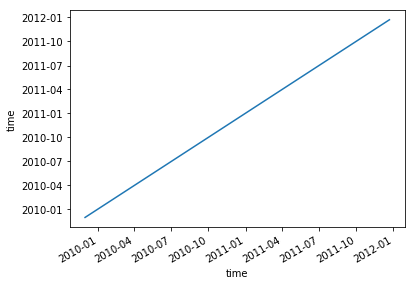

In [57]:
out_ds.time.plot()

In [63]:
domain_mean_rr = out_ds.rain_rate.mean(axis=1)
domain_mean_rr = domain_mean_rr.mean(axis=1)

e3sm_mean_rainfall = mean_rain_darwin*3
domain_mean_rr = domain_mean_rr.resample(time='3H').sum()/6
out_ds_averaged = out_ds.resample(time='3H').sum()/6
e3sm_mean_rainfall_4 = rain_darwin*3

In [77]:
print(out_ds_averaged)

<xarray.Dataset>
Dimensions:    (time: 6016, x: 2, y: 2)
Coordinates:
  * time       (time) datetime64[ns] 2009-11-30T03:00:00 2009-11-30T06:00:00 ...
  * x          (x) float64 -12.66 -11.25
  * y          (y) float64 130.8 132.2
Data variables:
    rain_rate  (time, x, y) float64 0.4849 1.096 2.047 1.786 0.7273 0.8264 ...


Text(0.5,1,'2010-2011')

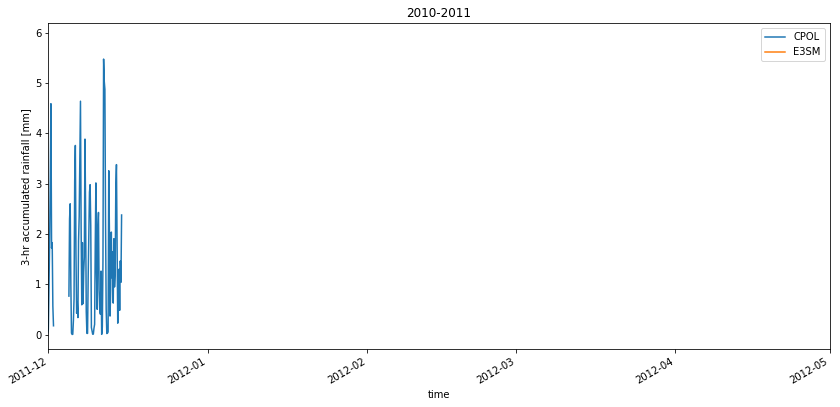

In [45]:
plt.figure(figsize=(14, 6))
domain_mean_rr.plot(label='CPOL')
e3sm_mean_rainfall.plot(label='E3SM')
plt.legend()
plt.xlim([datetime.datetime(2011, 12, 1), datetime.datetime(2012, 5, 1)])
plt.ylabel('3-hr accumulated rainfall [mm]')
plt.title('2010-2011')

In [7]:
def dt64_to_dt(dt):
    ts = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(ts)

hours_e3sm = np.array([dt64_to_dt(x).hour for x in e3sm_mean_rainfall.time.values])
hours_cpol = np.array([dt64_to_dt(x).hour for x in domain_mean_rr.time.values])
minute_e3sm = np.array([dt64_to_dt(x).minute for x in e3sm_mean_rainfall.time.values])
minute_cpol = np.array([dt64_to_dt(x).minute for x in domain_mean_rr.time.values])

# Convert to local time [UTC+9.5]
hours_e3sm = hours_e3sm + 9.5 + minute_e3sm/60
hours_e3sm[hours_e3sm >= 24] = hours_e3sm[hours_e3sm >= 24] - 24
hours_cpol = hours_cpol + 9.5 + minute_cpol/60
hours_cpol[hours_cpol >= 24] = hours_cpol[hours_cpol >= 24] - 24
hour_bins = np.arange(0, 25, 3)
rainfall_bins = np.logspace(-1, 1, 25)
cpol_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))
e3sm_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))

rr_e3sm = rain_darwin.values[:,0,1]
rr_cpol = out_ds_averaged.rain_rate.values[:,0,1]

for i in range(len(hour_bins)-1):
    inds = np.where(np.logical_and(hours_e3sm >= hour_bins[i], hours_e3sm < hour_bins[i+1]))[0]
    hist, bins = np.histogram(rr_e3sm[inds], bins=rainfall_bins)
    e3sm_diurnal_cycle_hist[i] = hist
    inds = np.where(np.logical_and(hours_cpol >= hour_bins[i], hours_cpol < hour_bins[i+1]))[0]
    hist, bins = np.histogram(rr_cpol[inds], bins=rainfall_bins)
    cpol_diurnal_cycle_hist[i] = hist

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5,1,'CPOL (Box 2)')

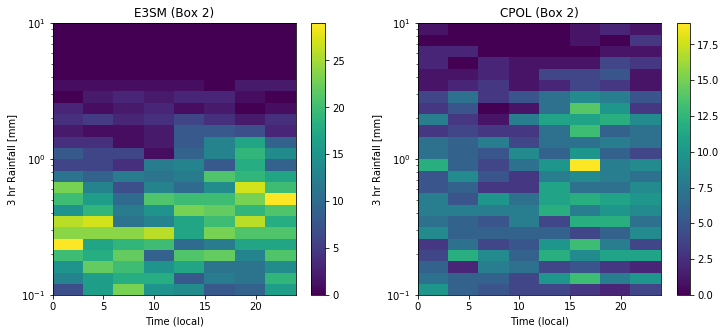

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
x, y = np.meshgrid(hour_bins, rainfall_bins)
mesh = ax[0].pcolormesh(x, y, e3sm_diurnal_cycle_hist.T)
plt.colorbar(mesh, ax =ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('3 hr Rainfall [mm]')
ax[0].set_xlabel('Time (local)')
ax[0].set_title('E3SM (Box 2)')

mesh = ax[1].pcolormesh(x, y, cpol_diurnal_cycle_hist.T)
plt.colorbar(mesh, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (local)')
ax[1].set_ylabel('3 hr Rainfall [mm]')
ax[1].set_title('CPOL (Box 2)')

In [93]:
out_ds_averaged

<xarray.Dataset>
Dimensions:    (time: 6016, x: 2, y: 2)
Coordinates:
  * time       (time) datetime64[ns] 2009-11-30T03:00:00 2009-11-30T06:00:00 ...
  * x          (x) float64 -12.66 -11.25
  * y          (y) float64 130.8 132.2
Data variables:
    rain_rate  (time, x, y) float64 0.4849 1.096 2.047 1.786 0.7273 0.8264 ...

In [16]:
print(out_ds_averaged.x.values[0])

-12.65625


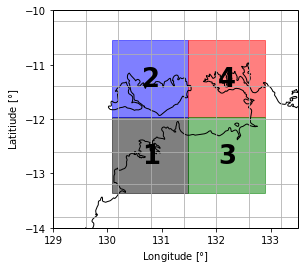

In [58]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.text(out_ds_averaged.y.values[0]-0.15, out_ds_averaged.x.values[0]-0.15, '1', fontsize=26, fontweight='bold')
plt.text(out_ds_averaged.y.values[0]-0.15, out_ds_averaged.x.values[1]-0.15, '2', fontsize=26, fontweight='bold')
plt.text(out_ds_averaged.y.values[1]-0.15, out_ds_averaged.x.values[0]-0.15, '3', fontsize=26, fontweight='bold')
plt.text(out_ds_averaged.y.values[1]-0.15, out_ds_averaged.x.values[1]-0.15, '4', fontsize=26, fontweight='bold')
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[0,0], lat_bnds[0,0]),
                              lon_bnds[0,1] - lon_bnds[0,0],
                              lat_bnds[0,1] - lat_bnds[0,0], fill=True, alpha=0.5,
                              edgecolor='k', color='k', linewidth=1)
                )
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[0,0], lat_bnds[0,1]),
                              lon_bnds[0,1] - lon_bnds[0,0],
                              lat_bnds[1,1] - lat_bnds[0,1], fill=True, alpha=0.5,
                              edgecolor='k', color='b', linewidth=1)
                )
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[1,0], lat_bnds[1,0]),
                              lon_bnds[1,1] - lon_bnds[1,0],
                              lat_bnds[1,1] - lat_bnds[1,0], fill=True, alpha=0.5,
                              edgecolor='k', color='r', linewidth=1)
                )
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[1,0], lat_bnds[0,0]),
                              lon_bnds[1,1] - lon_bnds[1,0],
                              lat_bnds[1,1] - lat_bnds[1,0], fill=True, alpha=0.5,
                              edgecolor='k', color='g', linewidth=1)
                )
ax.set_extent([129.5, 133.5, -14, -10])
ax.coastlines(resolution='10m')
#ax.add_feature(feature.LAND)
#ax.add_feature(feature.OCEAN)
ax.set_xticks([129, 130, 131, 132, 133])
ax.set_xlabel('Longitude [$\degree$]')
ax.set_ylabel('Latitiude [$\degree$]')
ax.set_yticks([-14, -13,- 12, -11, -10])
ax.gridlines()

In [222]:
bounding_box_1 = np.logical_and.reduce((ds_e3sm.PRECC.lat.values > -13.55,ds_e3sm.PRECC.lat.values < -10.94))
bounding_box_2 = np.logical_and.reduce((ds_e3sm.PRECC.lon.values > 129.7, ds_e3sm.PRECC.lon.values < 132.3))
U_darwin = ds_e3sm.U[:,:,bounding_box_1, bounding_box_2] 
V_darwin = ds_e3sm.V[:,:,bounding_box_1, bounding_box_2]


## Large scale forcing

In [49]:
dros_forcing = '/home/rjackson/data/Drosdowsky.cdf'
dros_ds = xarray.open_dataset(dros_forcing)
dros_ds

<xarray.Dataset>
Dimensions:  (time: 1819)
Dimensions without coordinates: time
Data variables:
    groups   (time) int32 ...
    year     (time) float64 ...
    month    (time) float64 ...
    day      (time) float64 ...
    cape     (time) float64 ...
    shear    (time) float64 ...
    rh500    (time) float64 ...

In [50]:
year_cpol = np.array([dt64_to_dt(x).year for x in domain_mean_rr.time.values])
month_cpol = np.array([dt64_to_dt(x).month for x in domain_mean_rr.time.values])
day_cpol = np.array([dt64_to_dt(x).day for x in domain_mean_rr.time.values])
year_dros = dros_ds.year.values
month_dros = dros_ds.month.values
day_dros = dros_ds.day.values

class_cpol = np.nan*np.ones(len(year_cpol))
for i in range(len(class_cpol)):
    the_index = np.where(np.logical_and.reduce((year_dros == year_cpol[i], 
                                                month_dros == month_cpol[i],
                                                day_dros == day_cpol[i])))[0]
    if(len(the_index) > 0):
        class_cpol[i] = dros_ds.groups.values[the_index]


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [51]:
bounding_box_1 = np.logical_and.reduce((ds_e3sm.PRECC.lat.values > -13.55,ds_e3sm.PRECC.lat.values < -10.94))
bounding_box_2 = np.logical_and.reduce((ds_e3sm.PRECC.lon.values > 129.7, ds_e3sm.PRECC.lon.values < 132.3))
U_e3sm = ds_e3sm.U[:,:,bounding_box_1, bounding_box_2].mean(axis=[2,3])
U_e3sm
U_e3sm.load()

<xarray.DataArray 'U' (time: 4129, lev: 72)>
array([[  6.659653,  -3.174256, -13.127542, ...,  -1.012613,  -0.754446,
         -0.413732],
       [  5.205791,  -1.959698,  -8.274486, ...,  -1.120577,  -0.937686,
         -0.648329],
       [ -3.69234 ,  -9.941418,  -9.243726, ...,  -1.121889,  -0.946744,
         -0.67933 ],
       ...,
       [ 14.970815,  24.998367,  34.39917 , ...,  -6.751969,  -5.486011,
         -3.68384 ],
       [ 16.901476,  26.726795,  35.894638, ...,  -6.673649,  -5.324526,
         -3.565127],
       [ 18.672247,  28.21759 ,  36.09556 , ...,  -6.428785,  -5.252678,
         -3.78795 ]], dtype=float32)
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 0.5885 0.8689 1.283 ...
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...

In [52]:
pres_levels = U_e3sm.lev
surface_to_500 = np.where(pres_levels > 500)[0]
upper = np.where(np.logical_and(pres_levels > 100, pres_levels < 300))[0]
DLM = np.zeros(len(U_e3sm.time.values))
U300100 = np.zeros(len(U_e3sm.time.values))
classification_Drosdowsky = np.zeros(len(U_e3sm.time.values))
for i in range(0,len(U_e3sm.time.values)):
    DLM[i] = sum(pres_levels[surface_to_500]*U_e3sm[i,surface_to_500]/(sum(pres_levels[surface_to_500])))
    U300100[i] = np.mean(U_e3sm[i,upper])
    
N = 1
break_spell = 0
U = 2.5
# Calculate Deep Layer Mean wind and classify time periods
j = 0
for i in range(0,len(DLM)-1):
    if(np.mean(DLM[i-N:i]) > U*(N+1)/N and DLM[i] > 0):
        if(U300100[i] < 0):
            N = N + 1
        else:
            if(N > 1):
                classification_Drosdowsky[j-N+1:j-1] = 1
                N = 1
    else:
        if(N > 1):
            classification_Drosdowsky[j-N+1:j-1] = 1
            N = 1
    j = j + 1

In [70]:
hours_e3sm = np.array([dt64_to_dt(x).hour for x in e3sm_mean_rainfall.time.values])
hours_cpol = np.array([dt64_to_dt(x).hour for x in domain_mean_rr.time.values])
minute_e3sm = np.array([dt64_to_dt(x).minute for x in e3sm_mean_rainfall.time.values])
minute_cpol = np.array([dt64_to_dt(x).minute for x in domain_mean_rr.time.values])

# Convert to local time [UTC+9.5]
hours_e3sm = hours_e3sm + 9.5 + minute_e3sm/60
hours_e3sm[hours_e3sm >= 24] = hours_e3sm[hours_e3sm >= 24] - 24
hours_cpol = hours_cpol + 9.5 + minute_cpol/60
hours_cpol[hours_cpol >= 24] = hours_cpol[hours_cpol >= 24] - 24
hour_bins = np.arange(0, 25, 3)
rainfall_bins = np.logspace(-1, 1, 25)
cpol_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))
e3sm_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))

rr_e3sm = e3sm_mean_rainfall_4.values[:,0,1]
rr_cpol = domain_mean_rr.values

dros = 1
for i in range(len(hour_bins)-1):
    inds = np.where(np.logical_and.reduce((
        classification_Drosdowsky == dros, hours_e3sm >= hour_bins[i], hours_e3sm < hour_bins[i+1])))[0]
    hist, bins = np.histogram(rr_e3sm[inds], bins=rainfall_bins)
    e3sm_diurnal_cycle_hist[i] = hist
    inds = np.where(np.logical_and.reduce(
        (class_cpol == dros, hours_cpol >= hour_bins[i], hours_cpol < hour_bins[i+1])))[0]
    hist, bins = np.histogram(rr_cpol[inds], bins=rainfall_bins)
    cpol_diurnal_cycle_hist[i] = hist

Text(0.5,1,'CPOL (total) Monsoon')

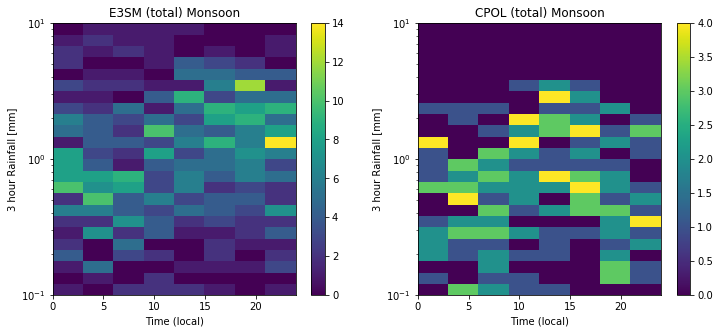

In [71]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
x, y = np.meshgrid(hour_bins, rainfall_bins)
mesh = ax[0].pcolormesh(x, y, e3sm_diurnal_cycle_hist.T)
plt.colorbar(mesh, ax =ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('3 hour Rainfall [mm]')
ax[0].set_xlabel('Time (local)')
ax[0].set_title('E3SM (total) Monsoon')

mesh = ax[1].pcolormesh(x, y, cpol_diurnal_cycle_hist.T)
plt.colorbar(mesh, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (local)')
ax[1].set_ylabel('3 hour Rainfall [mm]')
ax[1].set_title('CPOL (total) Monsoon')

In [48]:
print(e3sm_diurnal_cycle_hist)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
